In [204]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, QuantileTransformer, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from imblearn.pipeline import Pipeline

In [205]:
data=pd.read_csv("Train_set_halfprep.csv")

In [206]:
data.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


# Missing values imputation

In [207]:
cols_with_nans=data.isnull().sum()[data.isnull().sum()>0].index

Checking the distribution of each column with missing values

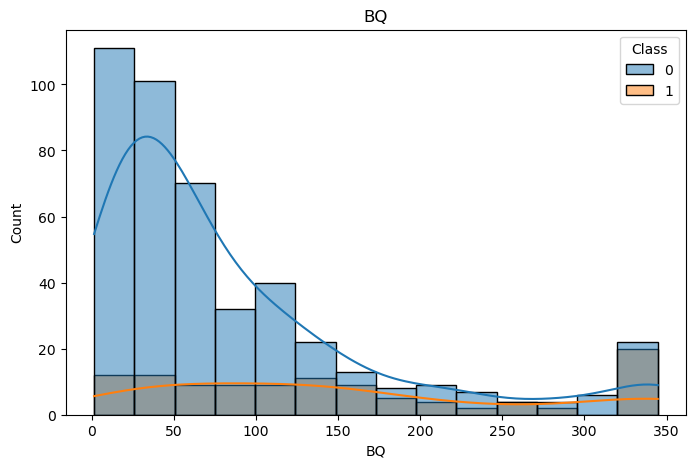

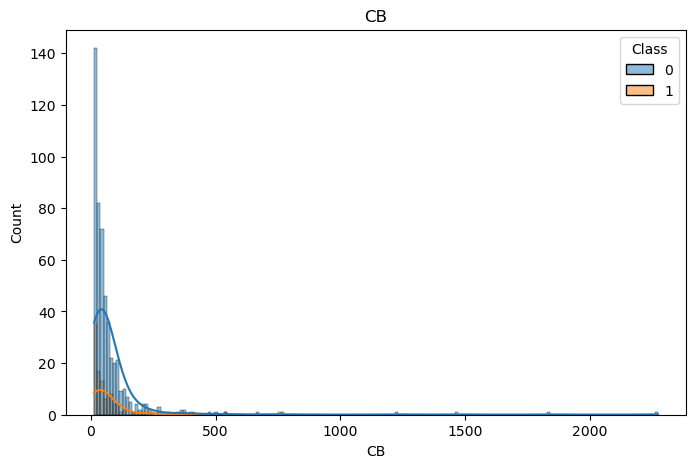

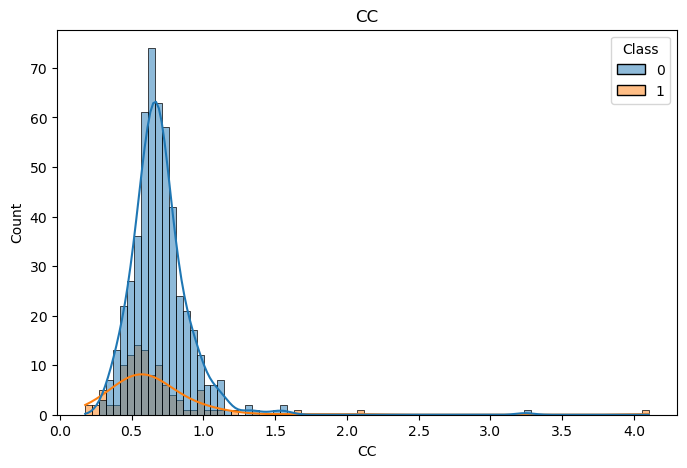

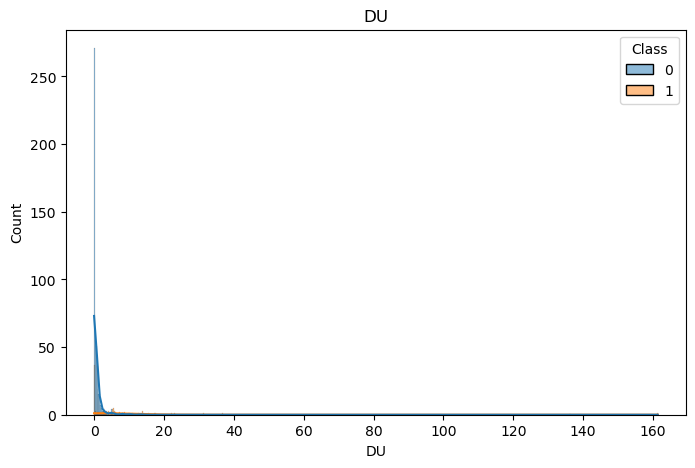

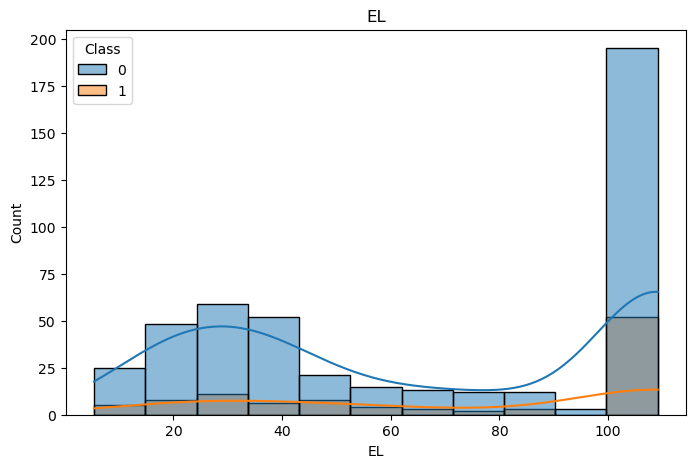

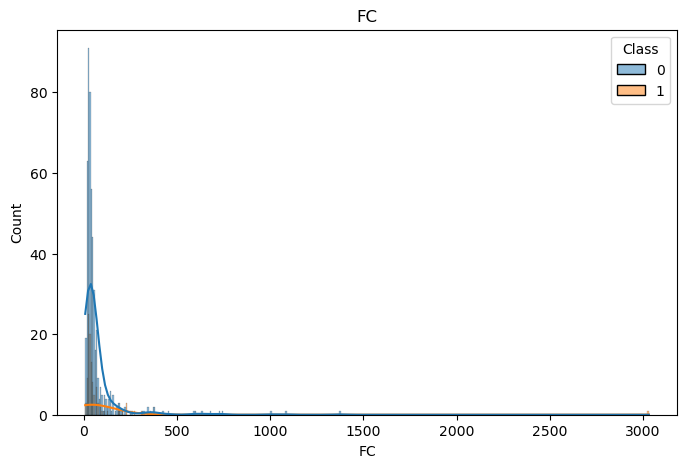

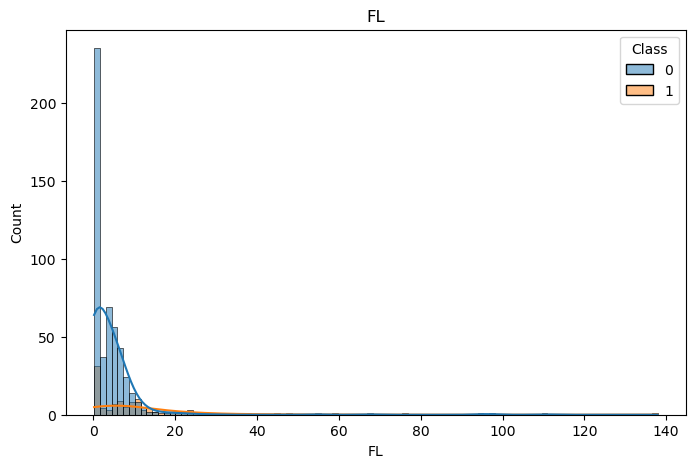

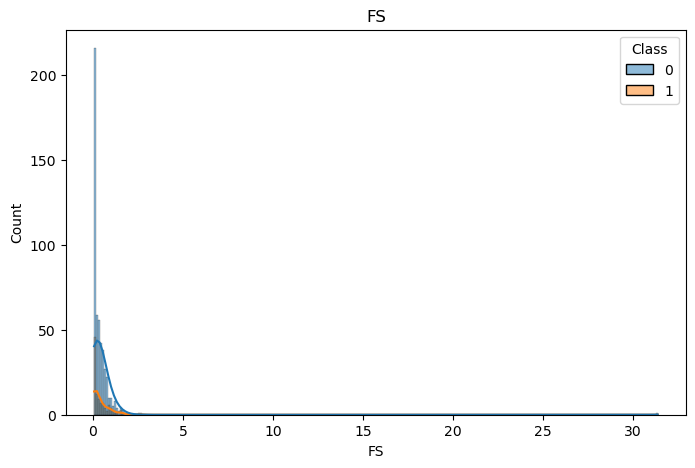

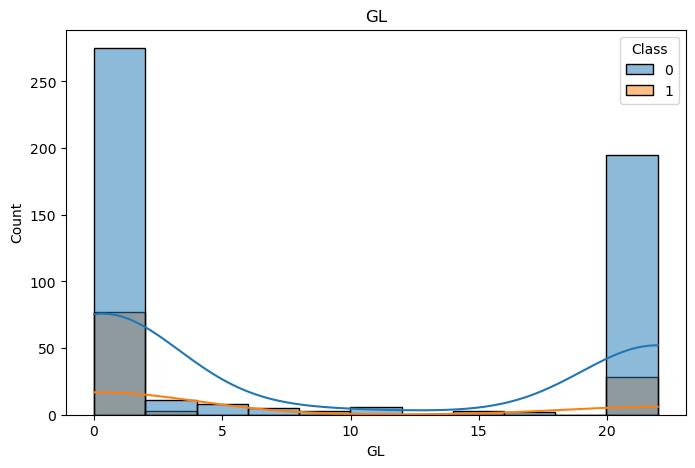

In [208]:
for col in cols_with_nans:
    fig, axes = plt.subplots(1, 1, figsize=(8, 5))
    sns.histplot(ax=axes, x=data[col], hue=data.Class, kde=True)
    axes.set_title(col)

In [209]:
for col in cols_with_nans:
    print(col,", ind missing vals: ", data[data[col].isna()].index)

BQ , ind missing vals:  Int64Index([  8,  15,  18,  23,  45,  46,  48,  64,  71, 119, 125, 128, 153,
            166, 177, 196, 231, 233, 235, 236, 244, 253, 263, 264, 266, 272,
            279, 281, 283, 285, 289, 305, 316, 341, 356, 358, 363, 364, 369,
            375, 422, 449, 458, 469, 492, 507, 517, 529, 537, 562, 568, 570,
            573, 579, 582, 583, 594, 602, 603, 615],
           dtype='int64')
CB , ind missing vals:  Int64Index([24, 114], dtype='int64')
CC , ind missing vals:  Int64Index([24, 114, 330], dtype='int64')
DU , ind missing vals:  Int64Index([594], dtype='int64')
EL , ind missing vals:  Int64Index([  8,  15,  18,  23,  45,  46,  48,  64,  71,  88, 119, 125, 128,
            153, 166, 177, 178, 231, 233, 235, 236, 244, 253, 263, 264, 266,
            272, 279, 281, 283, 285, 289, 304, 305, 316, 330, 341, 358, 363,
            364, 369, 375, 422, 458, 471, 490, 492, 507, 516, 517, 529, 537,
            570, 573, 579, 582, 583, 602, 603, 615],
           dtype='in

I drop the rows in which both EL and BQ are missing, since in these rows none of the other attributes above is missing and it could be that imputing missing values in these rows could introduce a non existing pattern in the data and so a bias. Moreover the features are anonymized therefore it's difficult to asses the nature of the missing values.  <br>
For GL,CB,CC,DU,FC,FL,FS and remaining missing vlaues of BQ I fill missing values with the median given the presence of outlier values that could influence the mean. While for GL and remaining missings of EL, that don't have outlier values, given their distribution, I replace missing values with the median as well. 

In [210]:
ind_EL_BQ_missing=data[(data.BQ.isna()& data.EL.isna())].index
data[cols_with_nans].iloc[ind_EL_BQ_missing].isna().sum()

BQ    53
CB     0
CC     0
DU     0
EL    53
FC     0
FL     0
FS     0
GL     0
dtype: int64

In [211]:
data.drop(ind_EL_BQ_missing, axis=0, inplace=True)

In order to avoid contamination of training data with test data I perform the imputation on the already splitted data, so on both train and test set separately.

# Splitting the data in train and test set, ratio: 75% training data, 25% testing data

In [212]:
train_set, test_set, target_train, target_test=train_test_split(data.drop('Class', axis=1), data.Class, test_size=0.25, stratify=data.Class, random_state=43, shuffle=True)

# Imputing missing values 
on training and test set separately to avoid data leakage.

In [213]:
def replace_missing_vals(col, strat):
    imputer=SimpleImputer(strategy=strat)
    return imputer.fit_transform(col.values.reshape(-1,1))[:,0]
for col in cols_with_nans:
        train_set[col]=replace_missing_vals(train_set[col],'median')
for col in cols_with_nans:
        test_set[col]=replace_missing_vals(test_set[col],'median')

In [214]:
(((train_set.isna()).sum())>0).sum(),(((test_set.isna()).sum())>0).sum()  #check

(0, 0)

# Feature transformation
Applying logarithmic transformation to make the distributions more uniform. Log reduces the ranges (the attributes have very different magnitudes) and then the influence of otuliers. Moreover the distributions become less skewed and more gaussian-like. This transformation doesn't need the data to be already splitted in train and test set, but first I had to replace missing values, hence the data is already splitted. Finally, I apply standard scaler, for which instead it's important that training and test data are separated (for computing mean and std all the data is used), to the attributes that are approximately gaussians.

In [215]:
numerical_f=list(train_set.select_dtypes(include=["float64"]).columns)

In [216]:
def log_transform(col):
    return np.log(col)
def sqrt_transform(col):
    return np.sqrt(col)
for col in numerical_f:
    train_set[col]=log_transform(train_set[col])
for col in numerical_f:
    test_set[col]=log_transform(test_set[col])

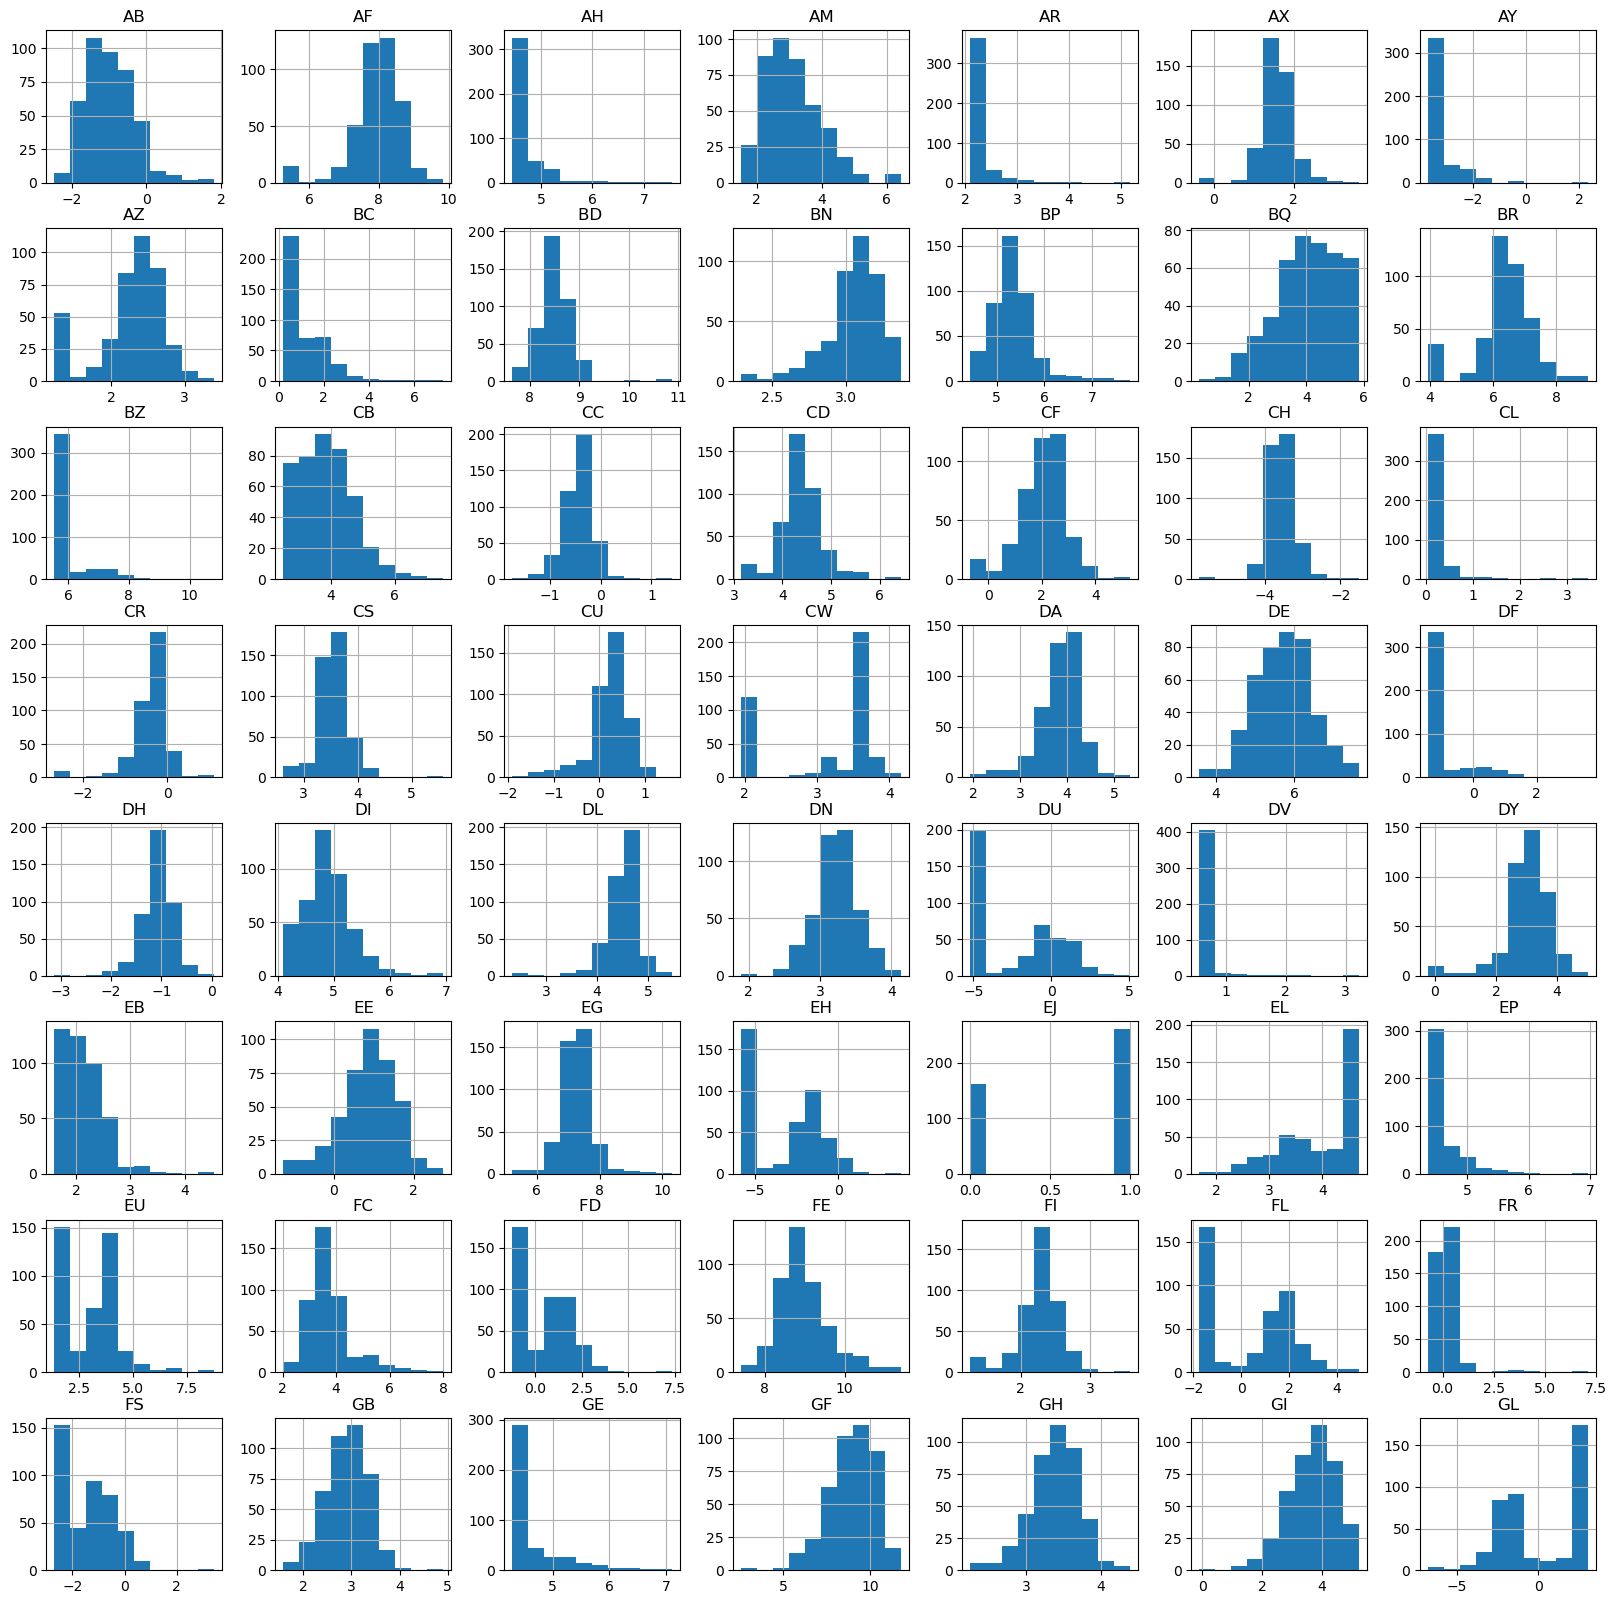

In [217]:
train_set.hist(figsize=(20,20));

Now all the features have similar magnitude.

Applying standard scaler (distributions are not changed) to approximately gaussian distributions:

In [218]:
approx_gaussians=['GH','GB','GI','GF','FI','EG','EE','DY','DL','DN','DH','DE','DA','DI','CF','CC','CD ','CH','CS','CR','BD ','BP','BR','AX','AB','AF']
scaler=StandardScaler()
train_set[approx_gaussians]=scaler.fit_transform(train_set[approx_gaussians])
test_set[approx_gaussians]=scaler.fit_transform(test_set[approx_gaussians])

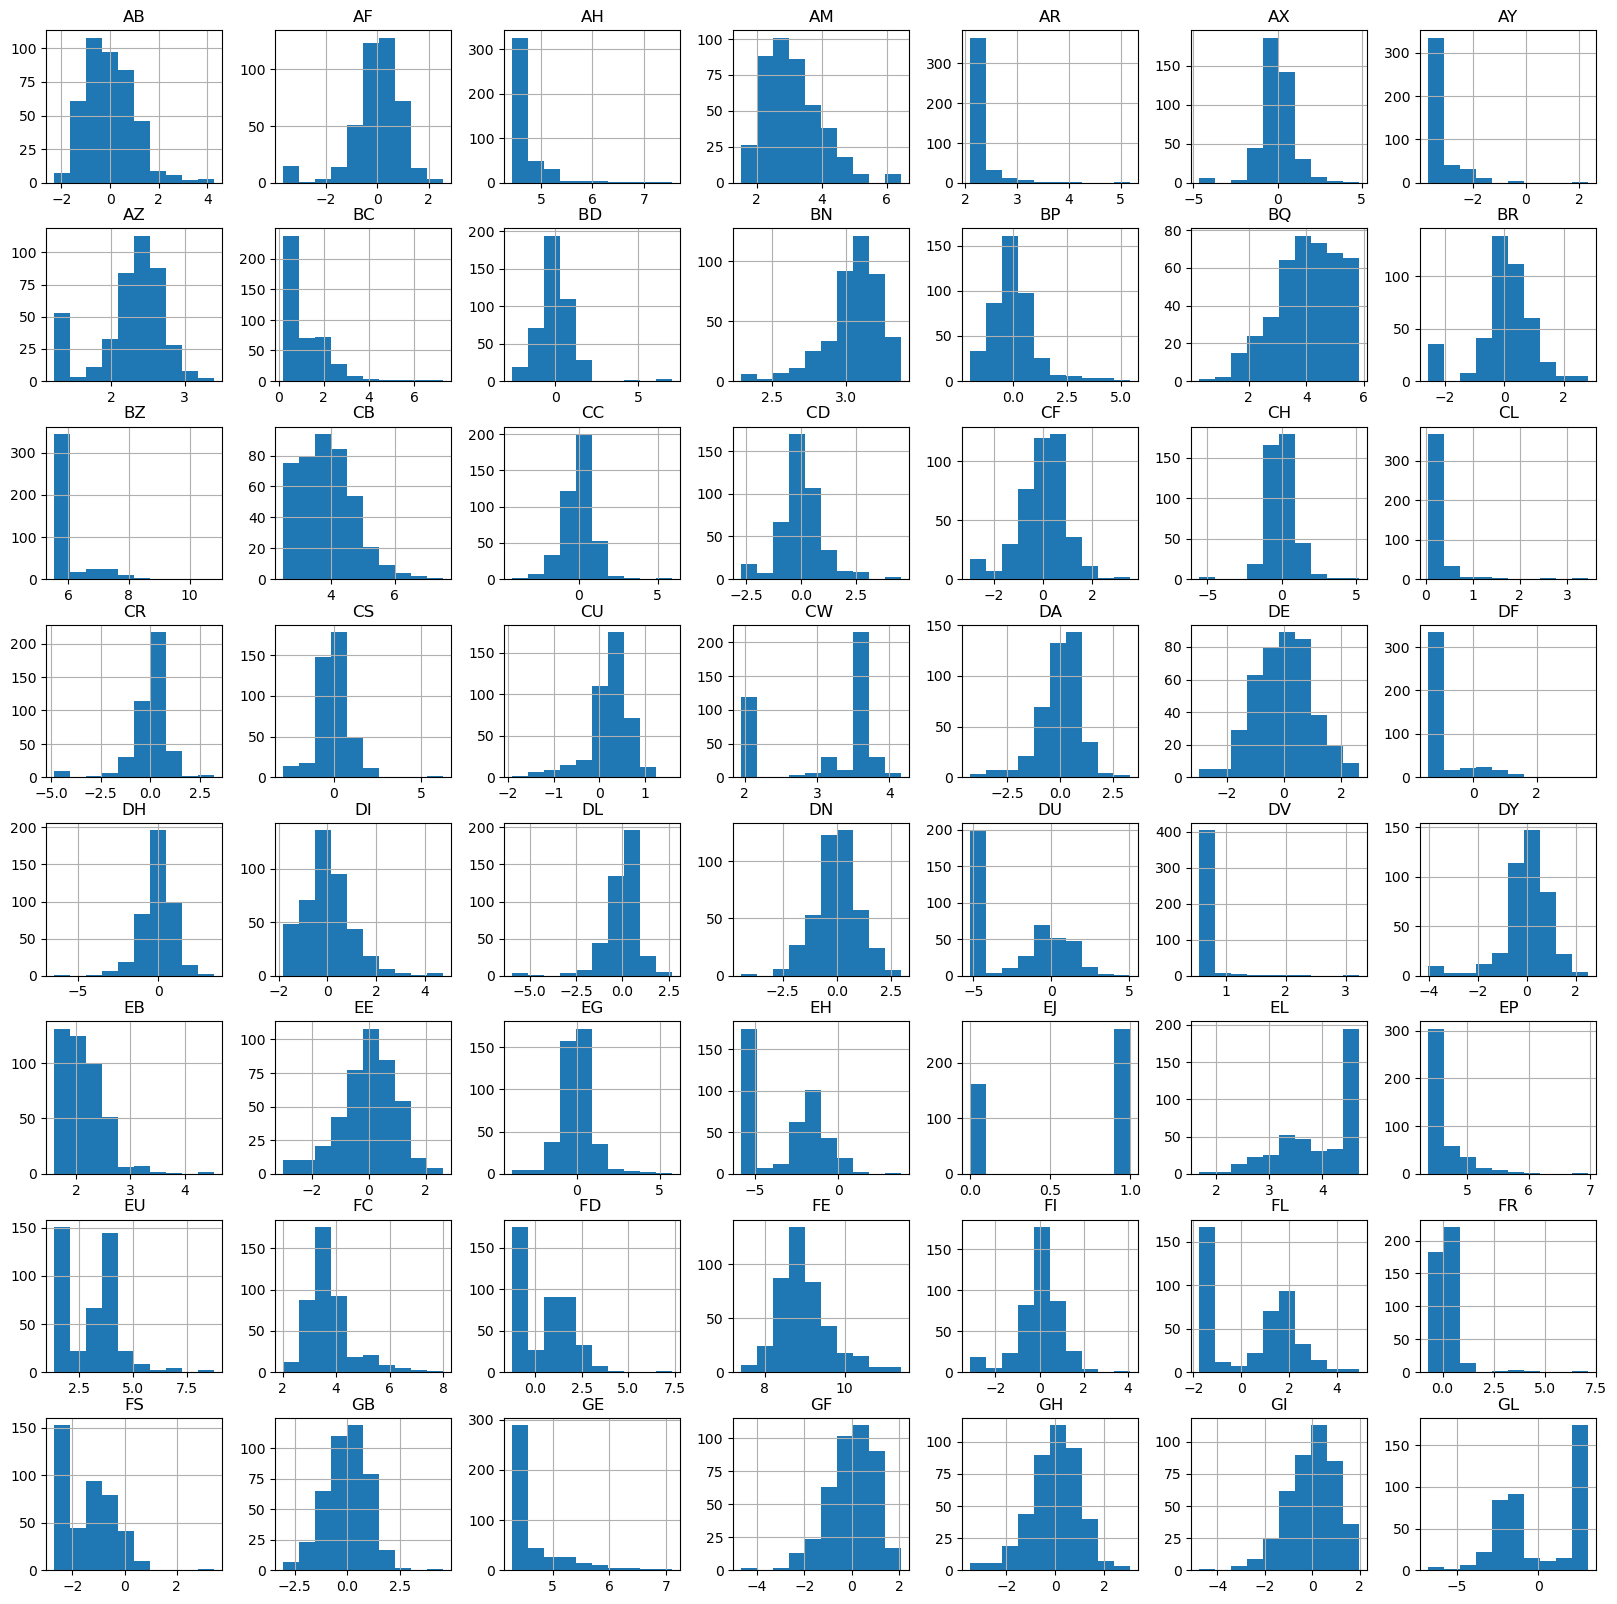

In [219]:
train_set.hist(figsize=(20,20));

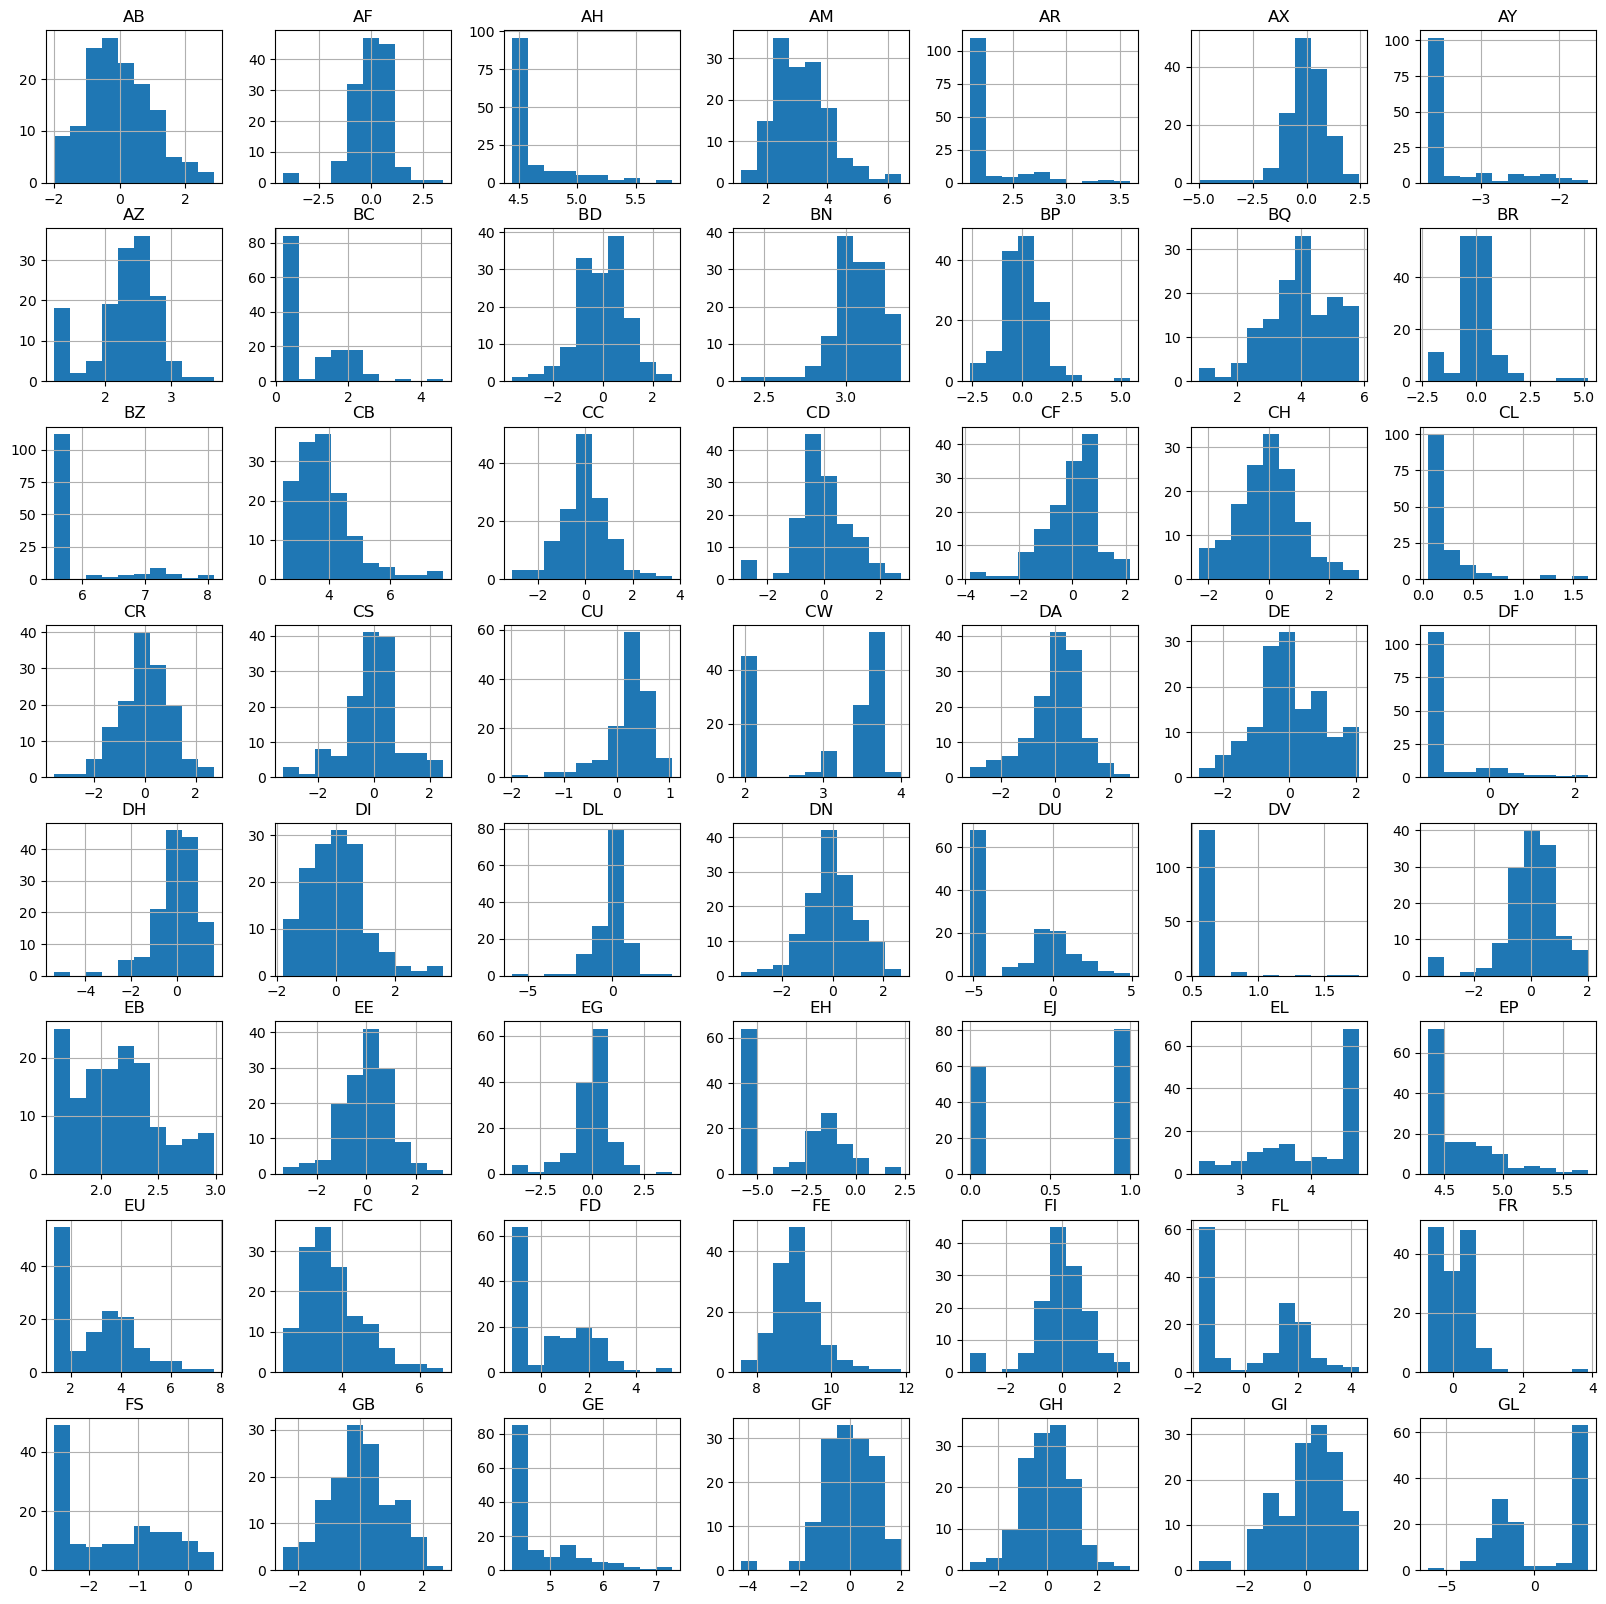

In [221]:
test_set.hist(figsize=(20,20));

In [220]:
train_set.to_csv("train_setpreproc.csv",index=False)
test_set.to_csv("test_setpreproc.csv",index=False)
target_test.to_csv("target_test.csv", index=False)
target_train.to_csv("target_train.csv", index=False)